In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import VotingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNetCV, SGDRegressor
from sklearn.metrics import root_mean_squared_error

## Custom Helper Functions

In [2]:
def plot_training_test_errors(train_errors, test_errors, values):
    print('Max training error:{:.2f} and min training error:{:.2f}'.format(max(train_errors), min(train_errors)))
    print('Max test error:{:.2f} and min test error:{:.2f}'.format(max(test_errors), min(test_errors)))
    
    plt.plot(train_errors, label='train error')
    plt.plot(test_errors, label='test error')
    plt.xticks(range(len(values)), values)
    plt.xlabel('Range')
    plt.legend()
    plt.show()

## Read Data

In [3]:
train = pd.read_csv('train.csv')
print("dimension of train data {}".format(train.shape))

dimension of train data (8523, 12)


In [4]:
train_x = train.drop(columns=['Item_Outlet_Sales'])
train_y = train['Item_Outlet_Sales']

## EDA

In [5]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Feature Engineering

In [7]:
num_col = train_x.select_dtypes(include = ['int64', 'float64']).columns
ohe_col = ['Item_Type']
ord_col = ['Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

In [8]:
outlet_size = ['Small', 'Medium', 'High']
outlet_location_type = ['Tier 1', 'Tier 2', 'Tier 3']
outlet_type = ['Supermarket Type1', 'Supermarket Type2', 'Supermarket Type3', 'Grocery Store']

oe = OrdinalEncoder(categories=[outlet_size, outlet_location_type, outlet_type],
                    handle_unknown='use_encoded_value', unknown_value=np.nan)

ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),
        ('ohe', OneHotEncoder(sparse_output=False), ohe_col),
        ('ord', oe, ord_col)
    ], remainder='drop', n_jobs=-1)

simple_pipe = Pipeline([
    ('transformer', ct),
    ('imputer', SimpleImputer(strategy='mean'))
])

knn_pipe = Pipeline([
    ('transformer', ct),
    ('imputer', KNNImputer(n_neighbors=5))
])

In [9]:
train_x_simple = simple_pipe.fit_transform(train_x)
train_x_knn = knn_pipe.fit_transform(train_x)

train_x_simple = pd.DataFrame(train_x_simple, 
                              columns=simple_pipe.get_feature_names_out())
train_x_knn = pd.DataFrame(train_x_knn,
                            columns=knn_pipe.get_feature_names_out())

## Correlation heatmap

<Axes: >

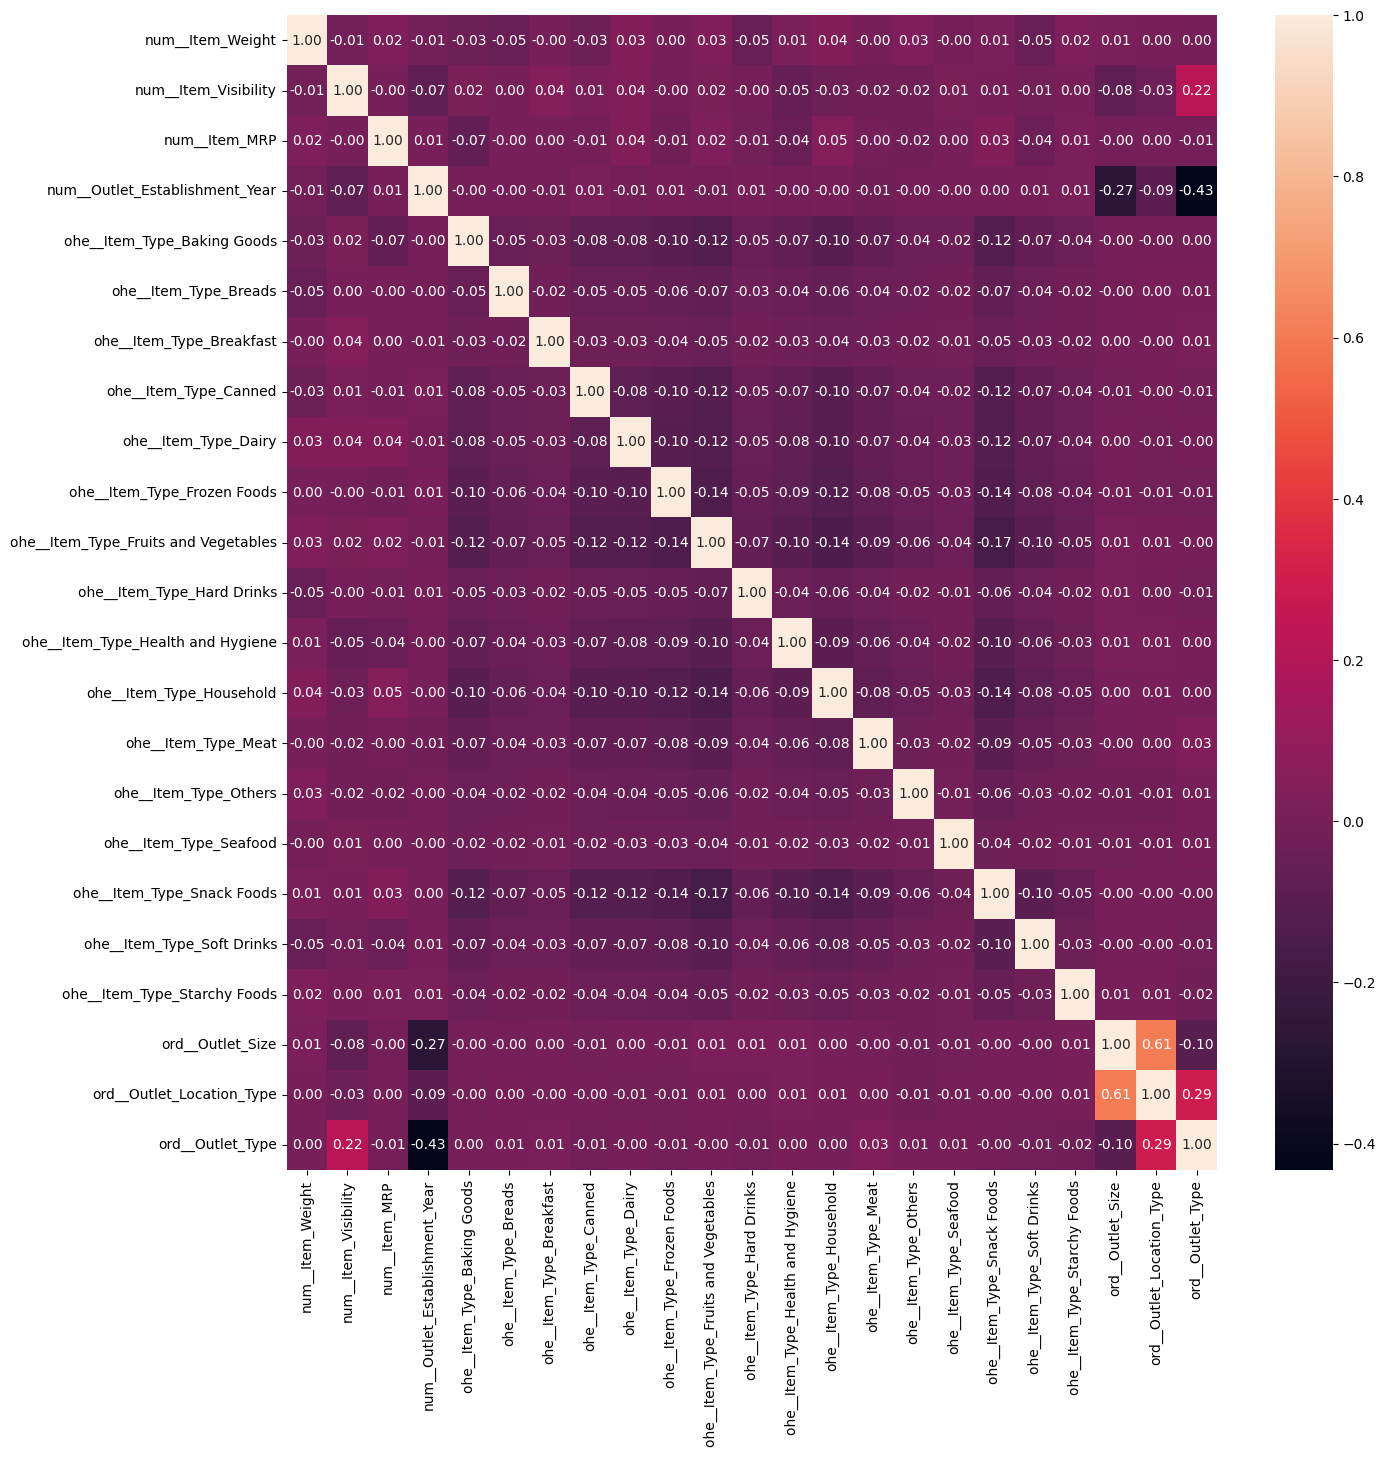

In [10]:
plt.figure(figsize=(15,15))

sns.heatmap(train_x_simple.corr(), annot=True, fmt='.2f')

<Axes: >

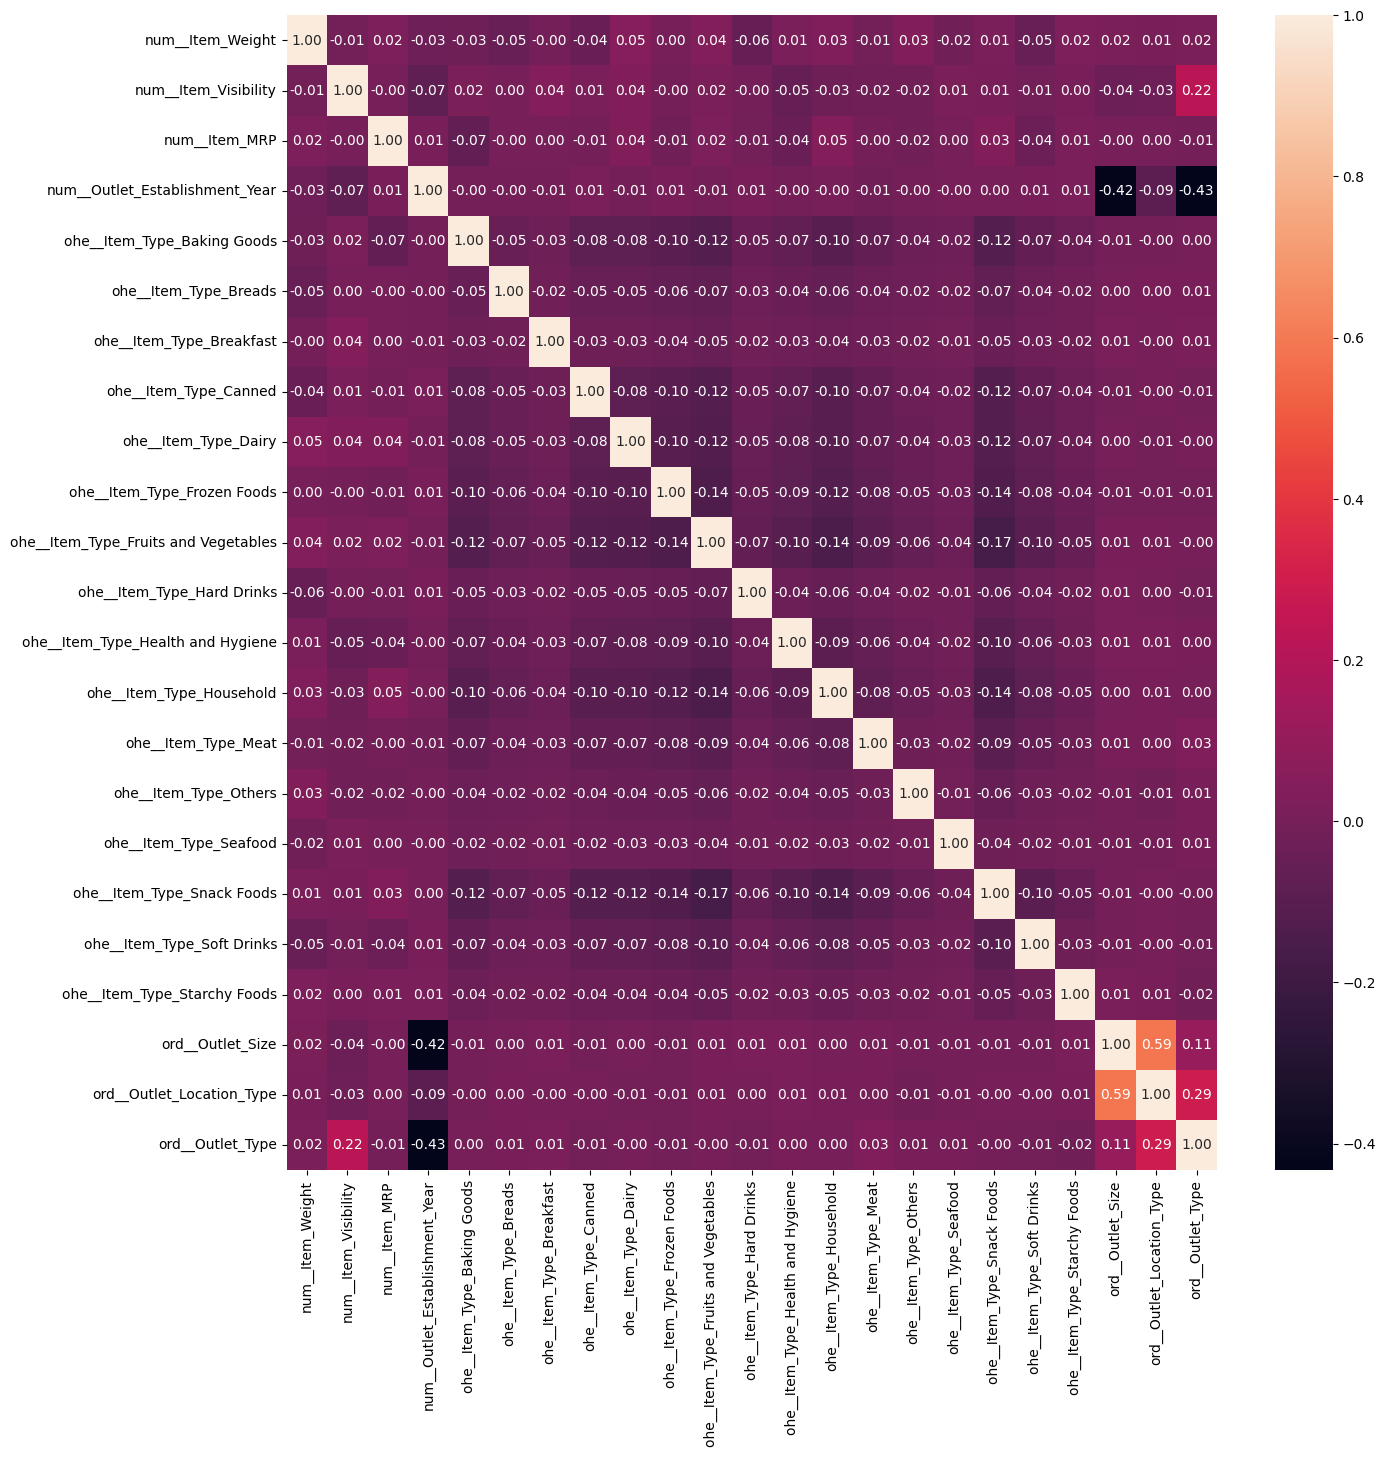

In [11]:
plt.figure(figsize=(15,15))

sns.heatmap(train_x_knn.corr(), annot=True, fmt='.2f')

## ML model

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

#### SGDReagressor

Max training error:1306.52 and min training error:1295.40
Max test error:1256.72 and min test error:1249.96


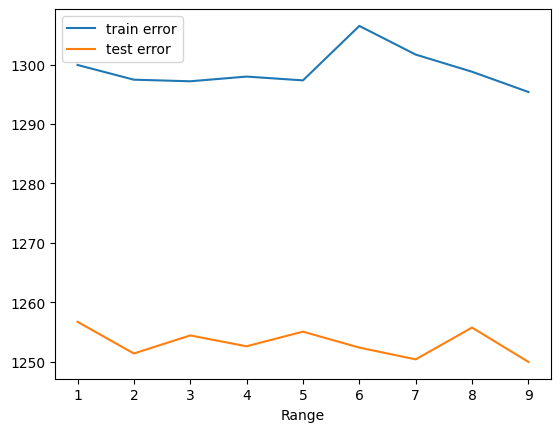

In [13]:
training_error = []
test_error = []

for i in range(1, 10):
    ml_simple_pipe = Pipeline([
        ('transformer', ct),
        ('imputer', SimpleImputer(strategy='mean')),
        ('model', SGDRegressor(l1_ratio=i/10, loss='squared_epsilon_insensitive', 
                               penalty='elasticnet', max_iter=2000))
    ])
    
    ml_simple_pipe.fit(X_train, y_train)
    
    y_train_pred = ml_simple_pipe.predict(X_train)
    y_test_pred = ml_simple_pipe.predict(X_test)
    
    training_error.append(root_mean_squared_error(y_train, y_train_pred))
    test_error.append(root_mean_squared_error(y_test, y_test_pred))


plot_training_test_errors(training_error, test_error, range(1, 10))

Max training error:1297.17 and min training error:1293.50
Max test error:1256.71 and min test error:1246.68


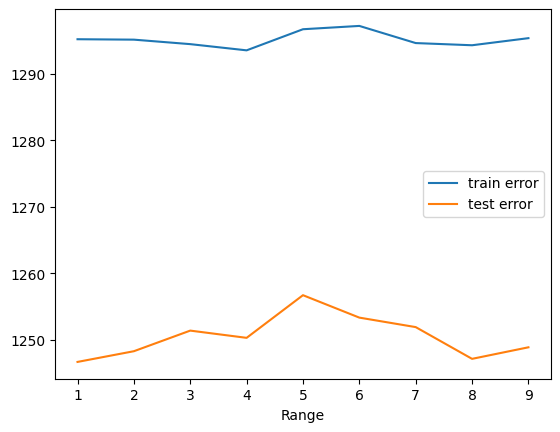

In [14]:
training_error = []
test_error = []

for i in range(1, 10):
    ml_knn_pipe = Pipeline([
        ('transformer', ct),
        ('imputer', KNNImputer(n_neighbors=12)),
        ('model', SGDRegressor(l1_ratio=i/10, loss='squared_epsilon_insensitive',
                                penalty='elasticnet', max_iter=2000))
    ])
    
    ml_knn_pipe.fit(X_train, y_train)
    
    training_error.append(root_mean_squared_error(y_train, ml_knn_pipe.predict(X_train)))
    test_error.append(root_mean_squared_error(y_test, ml_knn_pipe.predict(X_test)))

plot_training_test_errors(training_error, test_error, range(1, 10))

#### ElasticNetCV

Max training error:1651.40 and min training error:1310.51
Max test error:1584.32 and min test error:1258.13


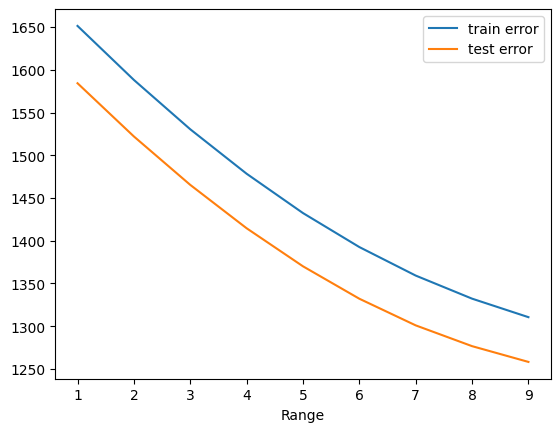

In [15]:
training_error = []
test_error = []

for i in range(1, 10):
    ml_simple_pipe = Pipeline([
        ('transformer', ct),
        ('imputer', SimpleImputer(strategy='mean')),
        ('model', ElasticNetCV(l1_ratio=i/10, n_jobs=-1))
    ])
    
    ml_simple_pipe.fit(X_train, y_train)
    
    y_train_pred = ml_simple_pipe.predict(X_train)
    y_test_pred = ml_simple_pipe.predict(X_test)
    
    training_error.append(root_mean_squared_error(y_train, y_train_pred))
    test_error.append(root_mean_squared_error(y_test, y_test_pred))


plot_training_test_errors(training_error, test_error, range(1, 10))

Max training error:1651.75 and min training error:1307.69
Max test error:1584.66 and min test error:1255.11


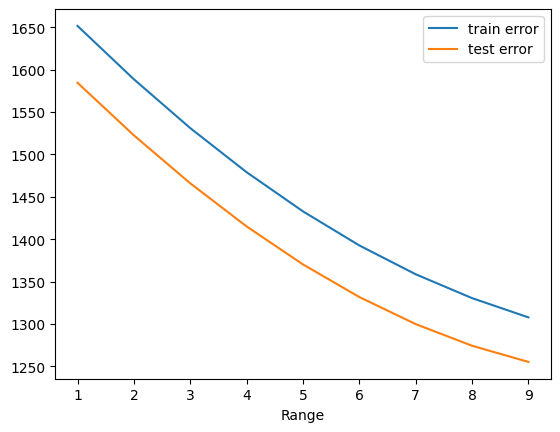

In [16]:
training_error = []
test_error = []

for i in range(1, 10):
    ml_knn_pipe = Pipeline([
        ('transformer', ct),
        ('imputer', KNNImputer(n_neighbors=12)),
        ('model', ElasticNetCV(l1_ratio=i/10, n_jobs=-1))
    ])
    
    ml_knn_pipe.fit(X_train, y_train)
    
    training_error.append(root_mean_squared_error(y_train, ml_knn_pipe.predict(X_train)))
    test_error.append(root_mean_squared_error(y_test, ml_knn_pipe.predict(X_test)))

plot_training_test_errors(training_error, test_error, range(1, 10))

#### ExtraTreesRegressor

Max training error:1481.33 and min training error:1005.48
Max test error:1411.33 and min test error:1016.22


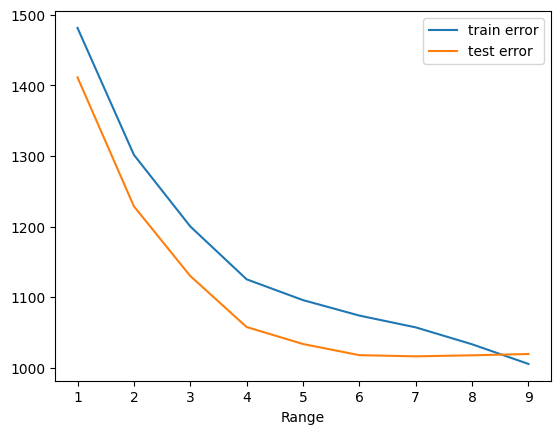

In [17]:
training_error = []
test_error = []

for i in range(1, 10):
    ml_simple_pipe = Pipeline([
        ('transformer', ct),
        ('imputer', SimpleImputer(strategy='mean')),
        ('model', ExtraTreesRegressor(max_depth=i, n_jobs=-1))
    ])
    
    ml_simple_pipe.fit(X_train, y_train)
    
    y_train_pred = ml_simple_pipe.predict(X_train)
    y_test_pred = ml_simple_pipe.predict(X_test)
    
    training_error.append(root_mean_squared_error(y_train, y_train_pred))
    test_error.append(root_mean_squared_error(y_test, y_test_pred))


plot_training_test_errors(training_error, test_error, range(1, 10))

Max training error:1480.34 and min training error:1000.67
Max test error:1410.18 and min test error:1016.59


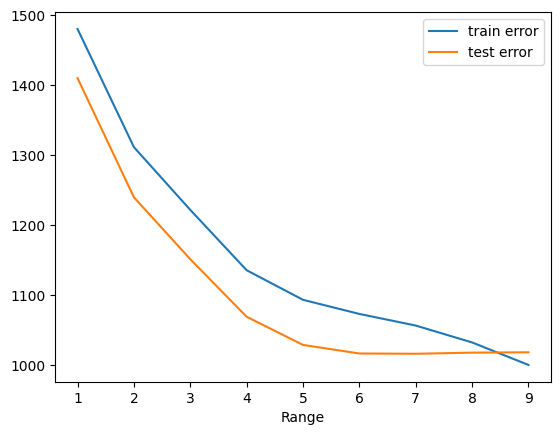

In [18]:
training_error = []
test_error = []

for i in range(1, 10):
    ml_knn_pipe = Pipeline([
        ('transformer', ct),
        ('imputer', KNNImputer(n_neighbors=16)),
        ('model', ExtraTreesRegressor(max_depth=i, n_jobs=-1))
    ])
    
    ml_knn_pipe.fit(X_train, y_train)

    training_error.append(root_mean_squared_error(y_train, ml_knn_pipe.predict(X_train)))
    test_error.append(root_mean_squared_error(y_test, ml_knn_pipe.predict(X_test)))

plot_training_test_errors(training_error, test_error, range(1, 10))

#### RandomForestRegressor

Max training error:1486.77 and min training error:963.71
Max test error:1426.70 and min test error:1021.74


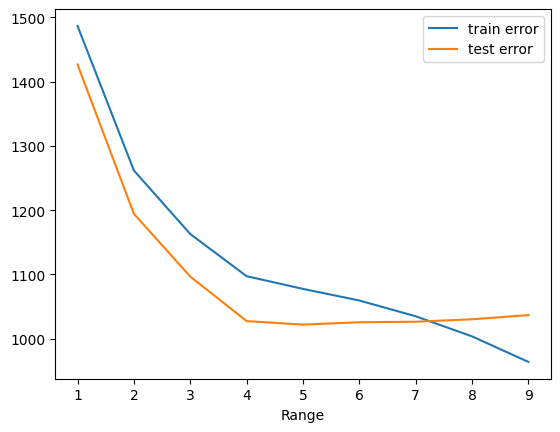

In [19]:
training_error = []
test_error = []

for i in range(1, 10):
    ml_simple_pipe = Pipeline([
        ('transformer', ct),
        ('imputer', SimpleImputer(strategy='mean')),
        ('model', RandomForestRegressor(max_depth=i, n_jobs=-1))
    ])
    
    ml_simple_pipe.fit(X_train, y_train)
    
    y_train_pred = ml_simple_pipe.predict(X_train)
    y_test_pred = ml_simple_pipe.predict(X_test)
    
    training_error.append(root_mean_squared_error(y_train, y_train_pred))
    test_error.append(root_mean_squared_error(y_test, y_test_pred))


plot_training_test_errors(training_error, test_error, range(1, 10))

Max training error:1485.35 and min training error:960.88
Max test error:1425.75 and min test error:1016.89


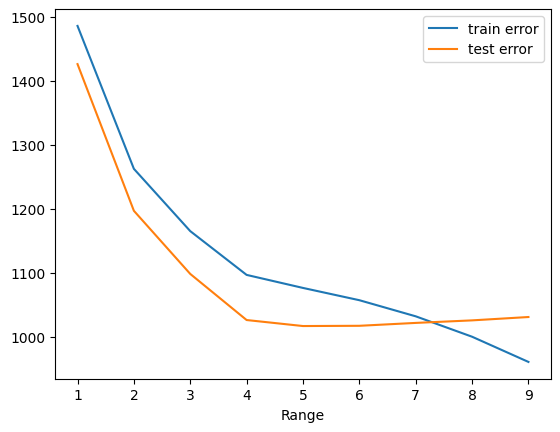

In [20]:
training_error = []
test_error = []

for i in range(1, 10):
    ml_knn_pipe = Pipeline([
        ('transformer', ct),
        ('imputer', KNNImputer(n_neighbors=12)),
        ('model', RandomForestRegressor(max_depth=i, n_jobs=-1))
    ])
    
    ml_knn_pipe.fit(X_train, y_train)
    
    training_error.append(root_mean_squared_error(y_train, ml_knn_pipe.predict(X_train)))
    test_error.append(root_mean_squared_error(y_test, ml_knn_pipe.predict(X_test)))

plot_training_test_errors(training_error, test_error, range(1, 10))

## Final model

In [21]:
simple_etr = Pipeline([
    ('transformer', ct),
    ('imputer', SimpleImputer(strategy='mean')),
    ('model', ExtraTreesRegressor(max_depth=7, n_jobs=-1))
])

knn_etr = Pipeline([
    ('transformer', ct),
    ('imputer', KNNImputer(n_neighbors=16)),
    ('model', ExtraTreesRegressor(max_depth=7, n_jobs=-1))
])

knn_rfr = Pipeline([
    ('transformer', ct),
    ('imputer', KNNImputer(n_neighbors=12)),
    ('model', RandomForestRegressor(max_depth=5, n_jobs=-1))
])

vt = VotingRegressor([
    ('simple_etr', simple_etr),
    ('knn_etr', knn_etr),
    ('knn_rfr', knn_rfr)
], n_jobs=-1)

vt.fit(train_x, train_y)
print('Train RMSE: {:.2f}'.format(root_mean_squared_error(train_y, vt.predict(train_x))))

Train RMSE: 1053.29


## Predict and save

In [22]:
test = pd.read_csv('test.csv')

test_serial_id = test[['Item_Identifier', 'Outlet_Identifier']]

predictions = vt.predict(test)
predictions = pd.DataFrame(predictions, columns=['Item_Outlet_Sales'])
submission = pd.concat([test_serial_id, predictions], axis=1)
submission.to_csv('submission.csv', index=False)